<a href="https://colab.research.google.com/github/R12942159/NTU_DLCV/blob/Hw3/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [5]:
import os
import json
import clip
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from google.colab import drive

#### Get cuda from GPU device.

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Connect google drive

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Download dataset and unzip zip file.

In [8]:
!gdown 11rP6KmR5Qwjhx0rfag0b5TZGBTRuPtQR -O hw3_data.zip
!unzip /content/hw3_data.zip

Downloading...
From: https://drive.google.com/uc?id=11rP6KmR5Qwjhx0rfag0b5TZGBTRuPtQR
To: /content/hw3_data.zip
100% 2.43G/2.43G [00:13<00:00, 179MB/s]
Archive:  /content/hw3_data.zip
replace hw3_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Construct image path

In [9]:
val_path = '/content/hw3_data/p1_data/val'
id2label_path = '/content/hw3_data/p1_data/id2label.json'

img_paths = [os.path.join(val_path, i) for i in os.listdir(val_path) if i.endswith('.png')]
id2label = json.load(open(id2label_path, 'r'))
labels = [l for _, l in id2label.items()]

#### Understand the image size and specifications

This is the image of 1330th, it is a fox.


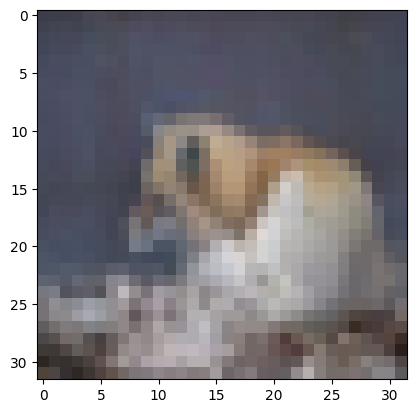

In [10]:
rd_int = random.randint(0, 2499)
class_num = img_paths[rd_int].split('/')[-1].split('_')[0]
print(f'This is the image of {rd_int}th, it is a {id2label[class_num]}.')

img = Image.open(img_paths[rd_int]).convert('RGB')
img = np.array(img)
img.shape

IMG_SIZE = img.shape[1]

plt.imshow(img)
plt.show()

#### Training with ["RN50", "RN101", "RN50x4", "RN50x16", "RN50x64", "ViT-B/32", "ViT-B/16", "ViT-L/14", "ViT-L/14@336px"]

In [11]:
def train(model_name = "RN50x64"):
    model, transform = clip.load(name=model_name, device=device, jit=False)

    ID, LABEL= [], []

    for path in tqdm(img_paths):
        img = Image.open(path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device) #  # resize to (1, 3, 448, 448), expected 4D input
        prompt_text = torch.cat(
            [clip.tokenize(f'A photo of a {i}', context_length=77, truncate=False) for i in labels]
        ).to(device)

        with torch.no_grad():
            img_features = model.encode_image(img) # (1, 1024)
            text_features = model.encode_text(prompt_text) # (50, 1024)

        # Pick the top 1 most similar labels for the image
        img_features /= img_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100. * img_features @ text_features.T).softmax(dim=-1)
        label = similarity[0].argmax()

        ID.append(path.split('/')[-1])
        LABEL.append(label.item()) # torch.Tensor -> int

    return ID, LABEL

In [12]:
ID, LABEL = train()

100%|██████████| 2500/2500 [06:25<00:00,  6.49it/s]


In [17]:
list(zip(ID, LABEL))

[('31_471.png', 31),
 ('42_494.png', 42),
 ('1_462.png', 1),
 ('35_489.png', 35),
 ('11_473.png', 11),
 ('33_452.png', 48),
 ('33_470.png', 33),
 ('43_487.png', 43),
 ('14_489.png', 14),
 ('22_492.png', 35),
 ('13_467.png', 23),
 ('31_458.png', 31),
 ('6_490.png', 23),
 ('2_492.png', 2),
 ('42_461.png', 42),
 ('10_494.png', 35),
 ('15_486.png', 25),
 ('4_480.png', 4),
 ('39_466.png', 39),
 ('12_462.png', 12),
 ('47_462.png', 11),
 ('24_497.png', 24),
 ('21_485.png', 21),
 ('42_478.png', 1),
 ('40_487.png', 37),
 ('49_485.png', 18),
 ('44_456.png', 44),
 ('15_495.png', 11),
 ('18_472.png', 23),
 ('8_473.png', 8),
 ('42_467.png', 42),
 ('49_461.png', 49),
 ('3_499.png', 3),
 ('44_452.png', 39),
 ('19_465.png', 19),
 ('5_497.png', 5),
 ('35_472.png', 35),
 ('15_483.png', 11),
 ('18_468.png', 18),
 ('23_485.png', 18),
 ('31_495.png', 31),
 ('5_487.png', 5),
 ('34_452.png', 34),
 ('2_453.png', 2),
 ('47_498.png', 37),
 ('14_468.png', 14),
 ('34_465.png', 34),
 ('24_455.png', 34),
 ('32_475.